# Imports

In [156]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# Settings base variables and paths

In [157]:
# Set the base folder path for the project
output_path = "../output"
images_path = os.path.join(output_path, "images")
metadata_path = os.path.join(output_path, "metadata")
config_path = os.path.join(output_path, "config")

list_of_paths = [output_path, images_path, metadata_path, config_path]

# Get the metadata from db and sort it with list into a dictionary

In [158]:
# Open a connection to the database
conn = sqlite3.connect(os.path.join(metadata_path, 'metadata.db'))
# Create a cursor
c = conn.cursor()
# Get a name of the first file in the images directory
metadata_file = os.listdir(images_path)
# Get the metadata of the first file

res = {}
for file in metadata_file :
    c.execute("SELECT * FROM metadata WHERE filename=?", (file,))
    # Print the metadata
    #Convert result to format: filename: [{key: value}...]
    metadata = c.fetchall()
    result = {}
    for row in metadata:
        if row[0] not in result:
            result[row[0]] = {}
        result[row[0]][row[1]] = row[2]
    res.update(result)

# créer des listes pour chaque prop
dict_metadata = {}

# liste toutes les propriétés des images
prop_list = []
for image in res:
    for prop in res[image]:
        if prop not in prop_list:
            prop_list.append(prop)

# ajout des props dans le dictionnaire
dict_metadata["file"] = []
for prop in prop_list:
    dict_metadata[prop] = []

# ajoute les valeurs des propriétés dans les listes
for image in res:
    dict_metadata["file"].append(image)
    for prop in prop_list:
        if prop in res[image]:
            dict_metadata[prop].append(res[image][prop])
        else:
            dict_metadata[prop].append(None)


for i in range(len(dict_metadata['Make'])):
    if dict_metadata['Make'][i] is not None:
        dict_metadata['Make'][i] = ''.join(filter(str.isalpha, dict_metadata['Make'][i])).replace('CORPORATION', '').replace('CORP', '').replace('COMPANY', '').replace('LTD', '').replace('IMAGING', '')

for i, key in enumerate(dict_metadata['DateTime']):
    if dict_metadata['DateTime'][i] is not None:
        dict_metadata['DateTime'][i] = dict_metadata['DateTime'][i].replace('T', ' ').replace('-', ':').split('+')[0]

# Close the connection
conn.close()

In [159]:
# compte les valeurs non null pour chaque propriété
# puis affiche les propriétés avec plus de 70 valeurs non nulles
prop_len = {}
for prop in dict_metadata:
    prop_len[prop] = len([x for x in dict_metadata[prop] if x is not None])
    if prop_len[prop] > 70:
        print(f'{prop} : {prop_len[prop]}')

file : 100
ResolutionUnit : 87
ExifOffset : 92
Make : 83
Model : 83
Software : 85
DateTime : 86
XResolution : 88
YResolution : 88
ExifVersion : 87
ShutterSpeedValue : 76
ApertureValue : 75
DateTimeOriginal : 85
DateTimeDigitized : 84
ExposureBiasValue : 81
MaxApertureValue : 71
MeteringMode : 82
CustomRendered : 79
Flash : 81
FocalLength : 82
ExposureMode : 82
WhiteBalance : 82
SceneCaptureType : 83
ExposureTime : 83
FNumber : 82
ExposureProgram : 80
ISOSpeedRatings : 83
tags : 100
dominant_color : 100
width : 96
height : 96
ColorSpace : 79


In [160]:
# affiche les 3 premiers éléments pour chaque liste
for prop in dict_metadata:
    if len(dict_metadata[prop]) > 70 and prop != "MakerNote":
        print(f'{prop} : {dict_metadata[prop][:3]}')


file : ['image_0.jpg', 'image_1.jpg', 'image_10.jpg']
ResolutionUnit : ['2', '2', '2']
ExifOffset : ['202', '246', '376']
Make : ['Canon', 'Panasonic', 'SONY']
Model : ['Canon EOS REBEL T3', 'DMC-GF1', 'SLT-A77V']
Software : ['Adobe Photoshop Lightroom 3.4', 'Adobe Photoshop Lightroom 5.6 (Macintosh)', 'SLT-A77V v1.07']
DateTime : ['2014:09:24 21:21:22', '2014:11:06 14:27:18', '2014:12:03 17:04:16']
XResolution : ['240.0', '240.0', '350.0']
YResolution : ['240.0', '240.0', '350.0']
ExifVersion : ["b'0230'", "b'0230'", "b'0230'"]
ShutterSpeedValue : ['6.643856', '7.643856', None]
ApertureValue : ['1.695994', '1.695994', None]
DateTimeOriginal : ['2014:09:24 20:09:26', '2013:12:07 12:17:20', '2014:12:03 17:04:16']
DateTimeDigitized : ['2014:09:24 20:09:26', '2013:12:07 12:17:20', '2014:12:03 17:04:16']
ExposureBiasValue : ['0.0', '0.0', '0.0']
MaxApertureValue : ['1.75', '1.53125', '4.96875']
MeteringMode : ['5', '5', '5']
CustomRendered : ['0', '0', '0']
Flash : ['16', '16', '16']
Focal

# Graph images : size

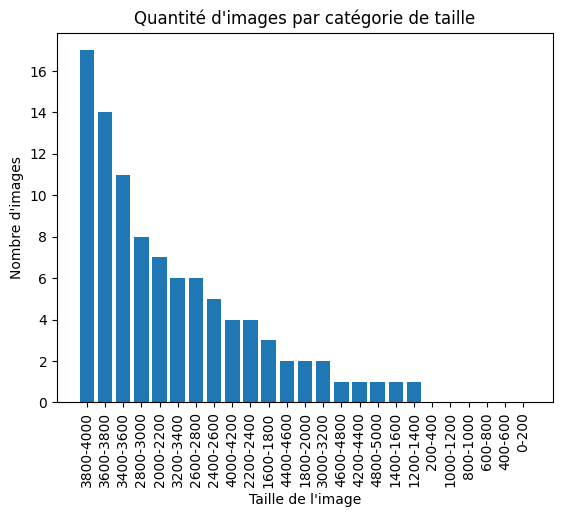

In [161]:
# interval des colonnes
bins_size = 200

# Convertir le dictionnaire en un DataFrame pandas
df = pd.DataFrame(dict_metadata)

# Créer une colonne pour la hauteur minimale
df['min_size'] = df[['width', 'height']].min(axis=1)

# Déterminer la hauteur minimale la plus grande
max_min_size = df['min_size'].max()

# Déterminer le nombre de bins nécessaires pour couvrir toutes les tailles d'image
num_bins = int(max_min_size / bins_size) + 1

# Définir les bins tous les 100 pixels
bins = [i * bins_size for i in range(num_bins + 1)]

# Définir les labels en utilisant des plages de pixels
labels = [f'{bins[i]}-{bins[i + 1]}' for i in range(num_bins)]

# Diviser la hauteur minimale en tranches de 100
df['size_category'] = pd.cut(df['min_size'], bins=bins, labels=labels)

# Compter le nombre d'images pour chaque catégorie de taille
size_counts = df['size_category'].value_counts()

# Créer un histogramme à barres en utilisant les données comptées
plt.bar(size_counts.index, size_counts.values)

# Ajouter des étiquettes d'axe et un titre
plt.xlabel('Taille de l\'image')
plt.ylabel('Nombre d\'images')
plt.title('Quantité d\'images par catégorie de taille')
plt.xticks(rotation=90)

# Afficher le graphique
plt.show()



In [162]:
# nb de colonnes
nb_colonnes = 7

# Convertir le dictionnaire en un DataFrame pandas
df = pd.DataFrame(dict_metadata)

# Créer une colonne pour la hauteur minimale
df['min_size'] = df[['height', 'width']].min(axis=1)

# Déterminer la hauteur minimale la plus grande
max_min_size = df['min_size'].max()

# Déterminer le nombre d'images
num_images = len(df)

# Déterminer le nombre de bins en fonction du nombre d'images et du nombre de colonnes souhaité
num_bins = int(num_images / (num_images / nb_colonnes))

# Définir les bins en utilisant le nombre de bins déterminé
bins = [i * (max_min_size / num_bins) for i in range(num_bins + 1)]

# Définir les labels en utilisant des plages de pixels
labels = [f'{int(bins[i])}-{int(bins[i + 1])}' for i in range(num_bins)]

# Diviser la hauteur minimale en tranches de 100
df['size_category'] = pd.cut(df['min_size'], bins=bins, labels=labels)

# Compter le nombre d'images pour chaque catégorie de taille
size_counts = df['size_category'].value_counts()

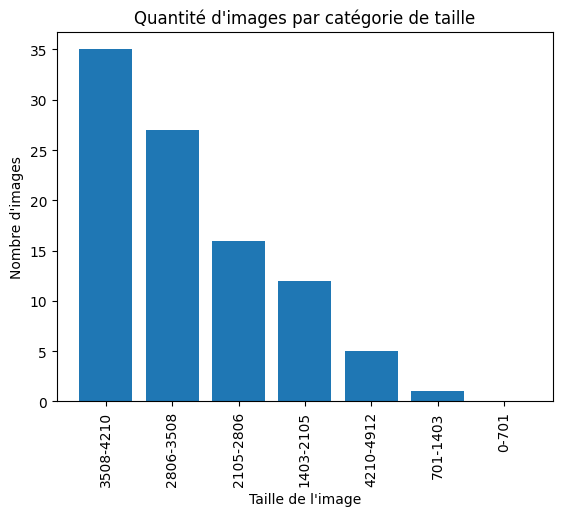

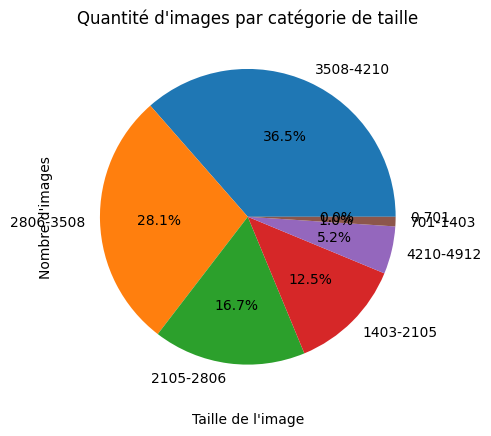

In [163]:
# Créer un histogramme à barres en utilisant les données comptées
plt.bar(size_counts.index, size_counts.values)
plt.xlabel('Taille de l\'image')
plt.ylabel('Nombre d\'images')
plt.title('Quantité d\'images par catégorie de taille')
plt.xticks(rotation=90)
plt.show()

plt.pie(size_counts.values, labels=size_counts.index, autopct='%1.1f%%')
plt.xlabel('Taille de l\'image')
plt.ylabel('Nombre d\'images')
plt.title('Quantité d\'images par catégorie de taille')
plt.show()


# Graph images : DateTime

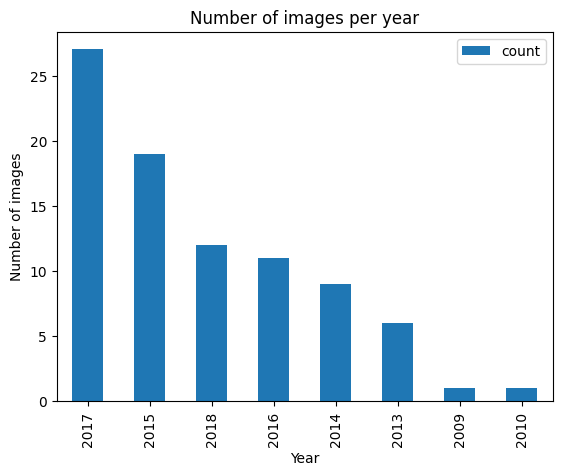

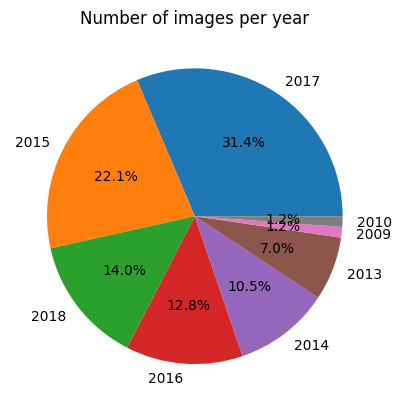

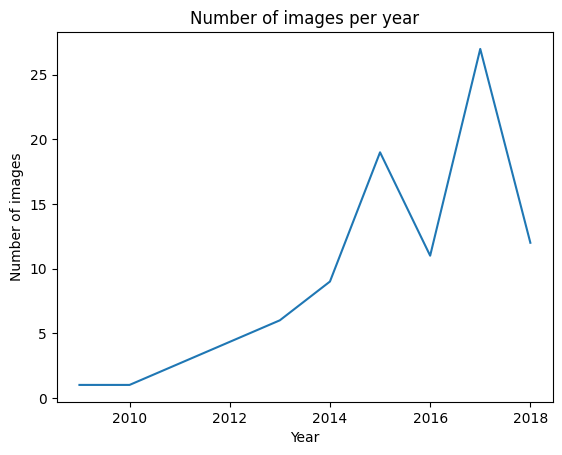

In [164]:
# Créer un DataFrame à partir du dictionnaire
df = pd.DataFrame(dict_metadata)

# Convertir les valeurs de DateTime en objets de type datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y:%m:%d %H:%M:%S')

# Ajouter une colonne pour l'année
df['Year'] = df['DateTime'].dt.year

# Grouper les images par année et compter le nombre d'images pour chaque année, puis trier les résultats par ordre décroissant de la valeur de la colonne 'Year'
image_count = df.groupby('Year').size().reset_index(name='count').sort_values('count', ascending=False)

# Convertir les années en entiers pour supprimer les décimales
image_count['Year'] = image_count['Year'].astype(int)

# Créer un graphique à barres pour visualiser le nombre d'images par année
image_count.plot(kind='bar', x='Year', y='count')
plt.xlabel('Year')
plt.ylabel('Number of images')
plt.title('Number of images per year')
plt.show()


plt.pie(image_count['count'], labels=image_count['Year'], autopct='%1.1f%%')
plt.title('Number of images per year')
plt.show()

# Grouper les images par année et compter le nombre d'images pour chaque année, puis trier les résultats par ordre croissant de la valeur de la colonne 'Year'
image_count = df.groupby('Year').size().reset_index(name='count').sort_values('Year', ascending=True)
plt.plot(image_count['Year'], image_count['count'])
plt.xlabel('Year')
plt.ylabel('Number of images')
plt.title('Number of images per year')
plt.show()


# Graph images : Make

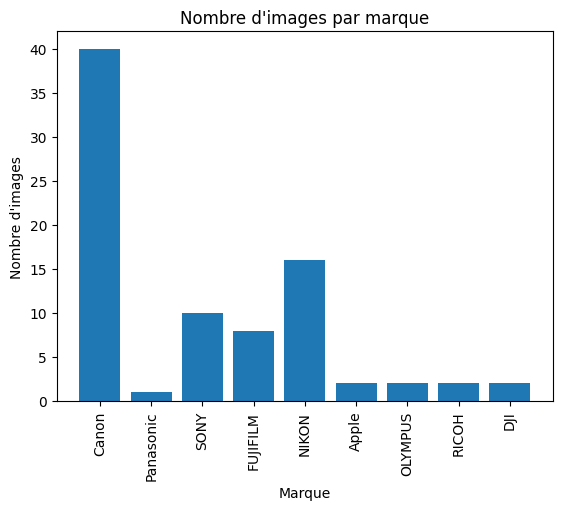

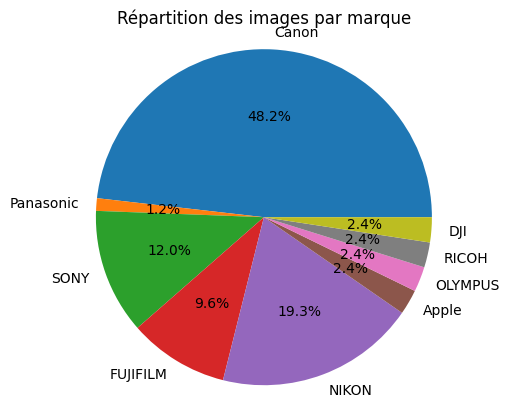

In [165]:
# initialiser un dictionnaire vide pour stocker le compte de chaque marque
counts = {}

# parcourir les valeurs de 'Make' et compter le nombre d'images associées à chaque marque
for make in dict_metadata['Make']:
    if make is not None:
        counts[make] = counts.get(make, 0) + 1

# convertir les résultats en listes pour la création du graphique
labels = list(counts.keys())
values = list(counts.values())

# créer le graphique en bâtons
plt.bar(labels, values)
plt.title('Nombre d\'images par marque')
plt.xlabel('Marque')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=90)
plt.show()


# Créer un graphique en camembert
labels = counts.keys()
sizes = counts.values()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Répartition des images par marque')
plt.show()